In [1]:
import pandas as pd
import os

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd

init_notebook_mode(connected = True)

In [2]:
def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
                            x = df.index,
                            y = df[column],
                            mode = 'lines',
                            name = column
                        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

Будем предсказывать просмотры wiki-страницы [Machine Learning](https://en.wikipedia.org/wiki/Machine_learning):

In [3]:
df = pd.read_csv('wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]

df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [4]:
df.shape

(383, 7)

In [5]:
df['date'] = pd.to_datetime(df['date'])
df.sample()

,date,count,lang,page,rank,month,title
148,2015-03-07,1432,en,Machine_learning,8708,201503,Machine_learning


In [6]:
plotly_df(df.set_index('date')[['count']])

Для начала построим предсказание с помощью простой библиотеки Facebook Prophet. Для того, чтобы посмотреть на качество модели, отбросим из обучающей выборки последние 30 дней:

In [7]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

import warnings
warnings.filterwarnings("ignore")

In [8]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
train_df = df[:-predictions].copy()
train_df.head()

,ds,y
81,2015-01-01,1414
80,2015-01-02,1920
79,2015-01-03,1338
78,2015-01-04,1404
77,2015-01-05,2264


In [9]:
test_df = df[(-predictions+1):].copy()

In [10]:
# Predictions are then made on a dataframe with a column ds containing the dates for which a prediction is to be made
model = Prophet()
model.fit(train_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [11]:
# The forecast object here is a new dataframe that includes a column yhat with the forecast, 
# as well as columns for components and uncertainty intervals
forecast = model.predict(test_df)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
24,2016-01-16,2119.447855,1733.281235,2535.740618
25,2016-01-17,2265.849218,1849.340467,2677.908963
26,2016-01-18,3273.333794,2855.351350,3687.011955
27,2016-01-19,3538.880873,3163.173202,3952.562626
28,2016-01-20,3428.415139,3006.149248,3821.244506


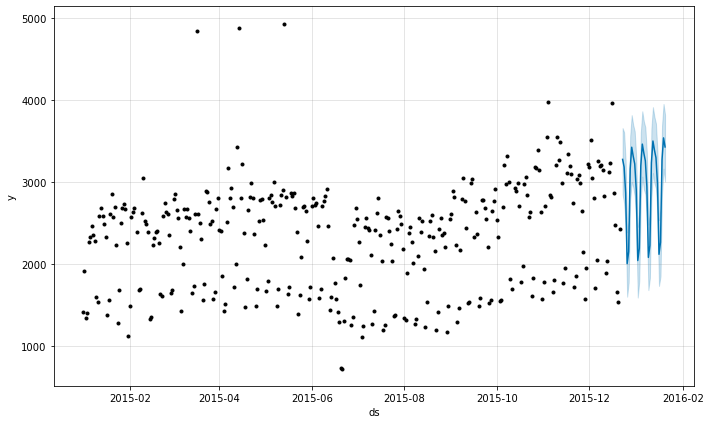

In [12]:
# Plot the forecast
model.plot(forecast);

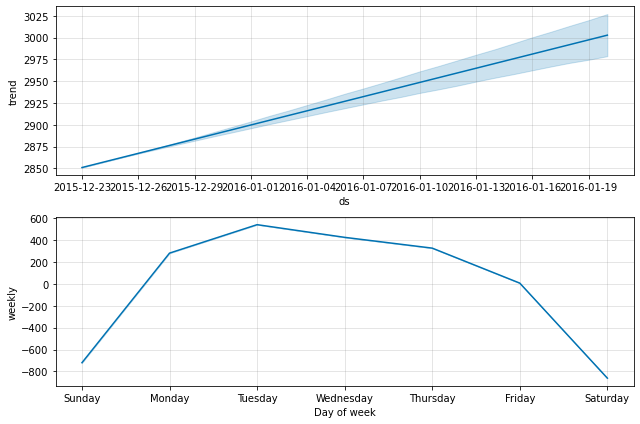

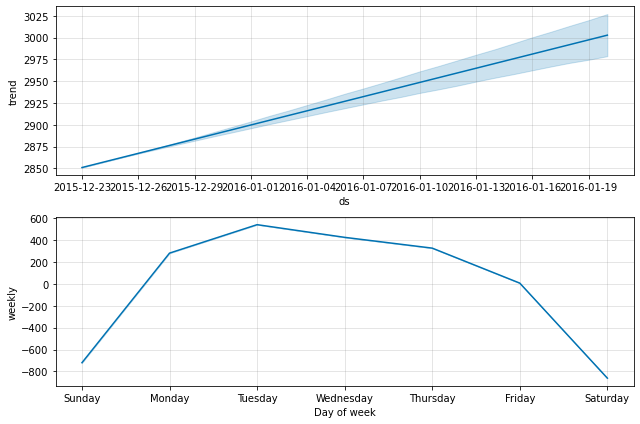

In [13]:
# Want to see the forecast components
model.plot_components(forecast)

In [14]:
# An interactive figure of the forecast
plot_plotly(model, forecast)

In [15]:
plot_components_plotly(model, forecast)

Оценим качество (MAE, MAPE) предсказания по последним 30 точкам:

In [16]:
from sklearn.metrics import mean_absolute_error
import numpy as np

In [17]:
# Является мерой точности предсказания метода прогнозирования в статистике, например, в оценке тренда 
# the closeness of g(X) to Y is measured via the MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    """
    Note: division by zero may occur, which will cause an error!
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    return np.mean(
                    np.abs((y_true - y_pred) / y_true) 
                ) * 100

In [18]:
forecast.sample()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
4,2015-12-27,2872.68456,1775.194605,2529.965728,2871.991606,2873.526624,-720.72828,-720.72828,-720.72828,-720.72828,-720.72828,-720.72828,0.0,0.0,0.0,2151.95628


In [19]:
df.sample()

,ds,y
125,2015-03-12,2565


In [20]:
df[-predictions+1:].shape

(29, 2)

In [21]:
forecast.shape

(29, 16)

In [22]:
print("MAE:", mean_absolute_error(df['y'][-predictions+1:], forecast['trend']))
print("MAPE: %.2f" % mean_absolute_percentage_error(df['y'][-predictions+1:], forecast['trend']), "%", sep='')

MAE: 753.9682538203916
MAPE: 44.57%


Я бы сказал, что ошибка MAE все-таки солидная: данные то у нас порядка 3000.
<br>MAPE также солидная.

---

Будем делать предсказания с помощью ARIMA:

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.tsa.api as smt
import statsmodels.api as sm

Проверим стационарность ряда с помощью критерия Дики-Фулера:

In [24]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['y'])[1])

Критерий Дики-Фуллера: p=0.015384


Критерий Дики-Фуллера теперь отвергает нулевую гипотезу о нестационарности на уровне значимости 2%,
поэтому данный ряд является стационарным.

Перейдем к построению модели SARIMAX (`sm.tsa.statespace.SARIMAX`):

In [25]:
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

In [26]:
#res = sm.tsa.seasonal_decompose(df['y'], freq=10)

#fig = res.plot()
#fig.set_figheight(8)
#fig.set_figwidth(15)

#plt.show()

In [27]:
model = sm.tsa.statespace.SARIMAX(df['y'])
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  383
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -3007.247
Date:                Sun, 20 Sep 2020   AIC                           6018.494
Time:                        13:42:11   BIC                           6026.391
Sample:                             0   HQIC                          6021.627
                                - 383                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9675      0.012     77.953      0.000       0.943       0.992
sigma2      3.847e+05   2.25e+04     17.112      0.000    3.41e+05    4.29e+05
Ljung-Box (Q):                     1628.76   Jarque-

In [28]:
# In-sample one-step-ahead predictions
predict = result.get_prediction()
predict_ci = predict.conf_int()

print(predict_ci[:5])

        lower y      upper y
81 -4805.921706  4805.921706
80   152.324940  2583.701959
79   641.868649  3073.245669
78    78.796635  2510.173655
77   142.650163  2574.027182


In [29]:
pred = predict_ci[['lower y', 'upper y']].mean(axis=1)

print("ARIMA MAE:", mean_absolute_error(df['y'][-predictions+1:], pred[-predictions+1:]))
print("ARIMA MAPE: %.2f" % mean_absolute_percentage_error(df['y'][-predictions+1:], pred[-predictions+1:]), 
                              "%", sep='')

ARIMA MAE: 421.4030126804612
ARIMA MAPE: 19.71%


Ошибка стала заметно меньше (MAE было 753.968), новая модель справляется лучше.
<br>MAPE также значимо уменьшилась (было 44.57%).

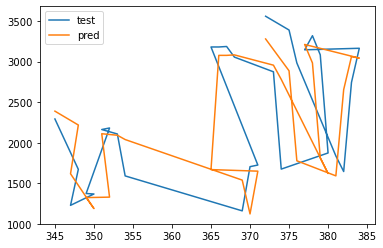

In [30]:
pd.DataFrame({'test':df['y'][-predictions+1:],'pred':pred[-predictions+1:]}).plot();plt.show()

1. **An autocorrelation plot** is designed to show whether the elements of a time series are positively correlated, negatively correlated, or independent of each other. An autocorrelation plot shows the value of the autocorrelation function (acf) on the vertical axis. It can range from –1 to 1.

    The horizontal axis of an autocorrelation plot shows the size of the lag between the elements of the time series. For example, the autocorrelation with lag 2 is the correlation between the time series elements and the corresponding elements that were observed two time periods earlier.

2. **A partial autocorrelation** is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

    The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags. The autocorrelation for an observation and an observation at a prior time step is comprised of both the direct correlation and indirect correlations. These indirect correlations are a linear function of the correlation of the observation, with observations at intervening time steps.  It is these indirect correlations that the partial autocorrelation function seeks to remove.

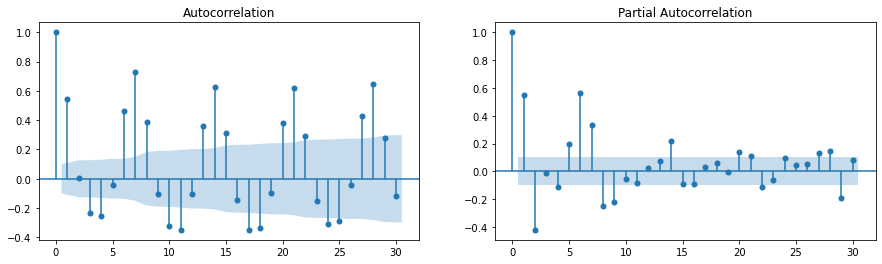

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(df['y'], lags=30, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(df['y'], lags=30, ax=axes[1])

Видим, что на остатках присутствует сезонность. Не есть хорошо.